In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [4]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [5]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 10

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, root):
        self.class_dict = {}
        self.image_folder = datasets.ImageFolder(root)
        transform = transforms.Compose([
                        transforms.Resize((100,100)),
                        transforms.ToTensor()
                    ])
        self.all_images = []
        
        # 1. separate paths by index, open image, and transform
        for path, class_index in self.image_folder.imgs:
            if class_index not in self.class_dict:
                self.class_dict[class_index] = []
            image = transform(
                        Image.open(path).convert('L') # L is grayscale mode
                    )
            self.class_dict[class_index].append(image)
            self.all_images.append((image, class_index))
            
        # 2. prepare dict of other indexes that are not current index (for random)
        indexes = [self.image_folder.class_to_idx[class_name]
                   for class_name in self.image_folder.classes]
        self.not_index = {}
        for index in indexes:
            new_indexes = indexes[:]
            new_indexes.remove(index)
            self.not_index[index] = new_indexes
        
    def get_images_by_class_index(self, class_index):
        return self.class_dict[class_index]
    
    def __getitem__(self, index):
        image_0, class_index_0 = random.choice(self.all_images)
        is_same_class = random.randint(0, 1)
        if is_same_class:
            class_index_1 = class_index_0
        else:
            # to make sure getting images from same class 50%
            class_index_1 = random.choice(self.not_index[class_index_0])
        image_1 = random.choice(self.get_images_by_class_index(class_index_1))
        
        return image_0, image_1, torch.tensor(is_same_class, dtype=torch.float32)
    def __len__(self):
        return len(self.image_folder.imgs)

In [7]:
siamese_dataset = SiameseNetworkDataset(root=Config.testing_dir)
data_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8)
example_batch = next(iter(data_loader))

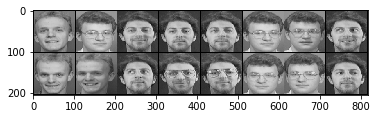

tensor([1., 0., 1., 1., 1., 1., 1., 1.])


In [8]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
img = torchvision.utils.make_grid(concatenated)
img = img.numpy()

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()
print(example_batch[2])

### Train

In [9]:
train_dataset = SiameseNetworkDataset(root=Config.training_dir)
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=8, batch_size=Config.train_batch_size)

In [10]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [11]:
counter = []
loss_history = [] 
for epoch in range(0, Config.train_number_epochs):
    for i, (image_1, image_2, is_same) in enumerate(train_dataloader):
        image_1 = image_1.to(device)
        image_2 = image_2.to(device)
        is_same = is_same.to(device)
        optimizer.zero_grad()
        y1, y2 = net(image_1, image_2)
        loss_contrastive = criterion(y1, y2, is_same)
        loss_contrastive.backward()
        optimizer.step()
    print(f'Epoch {epoch}, loss: {loss_contrastive.item()}')
    counter.append(epoch)
    loss_history.append(loss_contrastive.item())

Epoch 0, loss: 1.4041286706924438
Epoch 1, loss: 2.0179762840270996
Epoch 2, loss: 1.3373695611953735
Epoch 3, loss: 1.1263149976730347
Epoch 4, loss: 1.3761565685272217
Epoch 5, loss: 1.3797950744628906
Epoch 6, loss: 1.2662760019302368
Epoch 7, loss: 1.2956444025039673
Epoch 8, loss: 1.1280430555343628
Epoch 9, loss: 1.0192490816116333


In [12]:
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1000,shuffle=True)
for i in range(10):
    threshold = i/10
    print('threshold:',threshold)
    correct = 0
    for i, data in enumerate(test_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        output1,output2 = net(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        predict = (euclidean_distance > threshold).float()
        correct = predict.eq(label.squeeze()).sum().item()
    print(correct/len(test_dataloader.dataset))


threshold: 0.0
0.6
threshold: 0.1
0.5333333333333333
threshold: 0.2
0.3333333333333333
threshold: 0.3
0.5666666666666667
threshold: 0.4
0.36666666666666664
threshold: 0.5
0.36666666666666664
threshold: 0.6
0.36666666666666664
threshold: 0.7
0.5
threshold: 0.8
0.4666666666666667
threshold: 0.9
0.4666666666666667
